In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 200
%matplotlib inline

In [2]:
df = pd.read_json('newsgroups.json')

In [3]:
corpus = df.content
labels = df.target_names

In [4]:
corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if ...",rec.autos
1,"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9...",comp.sys.mac.hardware
2,"From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus f...",comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsread...,comp.graphics
4,"From: jcm@head-cfa.harvard.edu (Jonathan McDowell)\nSubject: Re: Shuttle Launch Question\nOrganization: Smithsonian Astrophysical Observatory, Cambridge, MA, USA\nDistribution: sci\nLines: 23\n\n...",sci.space
...,...,...
11309,"From: jim.zisfein@factory.com (Jim Zisfein) \nSubject: Re: Migraines and scans\nDistribution: world\nOrganization: Invention Factory's BBS - New York City, NY - 212-274-8298v.32bis\nReply-To: jim....",sci.med
11310,"From: ebodin@pearl.tufts.edu\nSubject: Screen Death: Mac Plus/512\nLines: 22\nOrganization: Tufts University - Medford, MA\n\nI have a (very old) Mac 512k and a Mac Plus, both of which \nhave the ...",comp.sys.mac.hardware
11311,From: westes@netcom.com (Will Estes)\nSubject: Mounting CPU Cooler in vertical case\nOrganization: Mail Group\nX-Newsreader: TIN [version 1.1 PL8]\nLines: 13\n\nI just installed a DX2-66 CPU in a ...,comp.sys.ibm.pc.hardware
11312,"From: steve@hcrlgw (Steven Collins)\nSubject: Re: Sphere from 4 points?\nOrganization: Central Research Lab. Hitachi, Ltd.\nLines: 27\nNntp-Posting-Host: hcrlgw\n\nIn article <1qkgbuINNs9n@shelley...",comp.graphics


In [5]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')


def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I | re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokeanize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc


normalize_corpus = np.vectorize(normalize_document)

In [6]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['lerxstwamumdedu wheres thing subject car nntppostinghost racwamumdedu organization university maryland college park lines wondering anyone could enlighten car saw day door sports car looked late early called bricklin doors really small addition front bumper separate rest body know anyone tellme model name engine specs years production car made history whatever info funky looking car please email thanks il brought neighborhood lerxst',
       'guykuocarsonuwashingtonedu guy kuo subject si clock poll final call summary final call si clock reports keywords siaccelerationclockupgrade articleid shelleyqvfoinncs organization university washington lines nntppostinghost carsonuwashingtonedu fair number brave souls upgraded si clock oscillator shared experiences poll please send brief message detailing experiences procedure top speed attained cpu rated speed add cards adapters heat sinks hour usage per day floppy disk functionality floppies especially requested summarizing next two days

# TF-IDF

In [7]:
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
# get bag of words features in sparse format
tfidf = TfidfVectorizer(min_df=0., max_df=1.)
tfidf_matrix = tfidf.fit_transform(norm_corpus)
tfidf_matrix

<11314x136501 sparse matrix of type '<class 'numpy.float64'>'
	with 1291838 stored elements in Compressed Sparse Row format>

In [8]:
vocab = tfidf.get_feature_names()

# c-TF-IDF

In [9]:
import numpy as np
import scipy.sparse as sp

from sklearn.utils import check_array
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.utils.validation import FLOAT_DTYPES, check_is_fitted


class CTFIDFVectorizer(TfidfTransformer):
    def __init__(self, *args, **kwargs):
        super(CTFIDFVectorizer, self).__init__(*args, **kwargs)
        self._idf_diag = None

    def fit(self, X: sp.csr_matrix, n_samples: int):
        """Learn the idf vector (global term weights)

        Parameters
        ----------
        X : sparse matrix of shape n_samples, n_features)
            A matrix of term/token counts.

        """

        # Prepare input
        X = check_array(X, accept_sparse=('csr', 'csc'))
        if not sp.issparse(X):
            X = sp.csr_matrix(X)
        dtype = X.dtype if X.dtype in FLOAT_DTYPES else np.float64

        # Calculate IDF scores
        _, n_features = X.shape
        df = np.squeeze(np.asarray(X.sum(axis=0)))
        avg_nr_samples = int(X.sum(axis=1).mean())
        idf = np.log(avg_nr_samples / df)
        self._idf_diag = sp.diags(idf, offsets=0,
                                  shape=(n_features, n_features),
                                  format='csr',
                                  dtype=dtype)
        return self

    def transform(self, X: sp.csr_matrix, copy=True) -> sp.csr_matrix:
        """Transform a count-based matrix to c-TF-IDF

        Parameters
        ----------
        X : sparse matrix of (n_samples, n_features)
            a matrix of term/token counts

        Returns
        -------
        vectors : sparse matrix of shape (n_samples, n_features)

        """

        # Prepare input
        X = check_array(X, accept_sparse='csr', dtype=FLOAT_DTYPES, copy=copy)
        if not sp.issparse(X):
            X = sp.csr_matrix(X, dtype=np.float64)

        n_samples, n_features = X.shape

        # idf_ being a property, the automatic attributes detection
        # does not work as usual and we need to specify the attribute
        # name:
        check_is_fitted(self, attributes=["idf_"],
                        msg='idf vector is not fitted')

        # Check if expected nr features is found
        expected_n_features = self._idf_diag.shape[0]
        if n_features != expected_n_features:
            raise ValueError("Input has n_features=%d while the model"
                             " has been trained with n_features=%d" % (
                                 n_features, expected_n_features))

        X = X * self._idf_diag

        if self.norm:
            X = normalize(X, axis=1, norm='l1', copy=False)

        return X

In [10]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
#from ctfidf import CTFIDFVectorizer

# Create c-TF-IDF
docs_cv = CountVectorizer().fit_transform(norm_corpus)
docs_ctfidf = CTFIDFVectorizer().fit_transform(docs_cv, n_samples=len(corpus_df))

# Performance

In [11]:
# log-likelihood
print(lda.score(tfidf_matrix))
# perplexity
print(lda.perplexity(tfidf_matrix))

-986507.5668425211
64886.73472061655


In [12]:
import tmtoolkit
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
def topic_model_coherence_generator(topic_num_start=1,
                                    topic_num_end=5,
                                    norm_corpus='',
                                    cv_matrix='',
                                    cv=''):
    norm_corpus_tokens = [doc.split() for doc in norm_corpus]
    models = []
    coherence_scores = []

    for i in range(topic_num_start, topic_num_end):
        print(i)
        cur_lda = LatentDirichletAllocation(n_components=i,
                                            max_iter=10,
                                            random_state=0)
        cur_lda.fit_transform(cv_matrix)
        cur_coherence_score = metric_coherence_gensim(
            measure='c_v',
            top_n=5,
            topic_word_distrib=cur_lda.components_,
            dtm=cv.fit_transform(norm_corpus),
            vocab=np.array(cv.get_feature_names()),
            texts=norm_corpus_tokens)
        models.append(cur_lda)
        coherence_scores.append(np.mean(cur_coherence_score))
    return models, coherence_scores

In [15]:
%%time
ts = 2
te = 6
models, coherence_scores = topic_model_coherence_generator(
    ts, te, norm_corpus=norm_corpus, cv=tfidf, cv_matrix=tfidf_matrix)

2
3
4
5
Wall time: 6min 9s


In [16]:
coherence_scores

[0.7521630524212832,
 0.7397422943391275,
 0.5968501750719519,
 0.5042511833904781]

In [17]:
from statistics import mean
mean(coherence_scores)

0.6482516763057102

# Hybrid Model

In [18]:
## doc-topic matrix
doc_topic_df = pd.DataFrame(doc_topic_matrix, columns=['T1', 'T2', 'T3'])
doc_topic_df

,T1,T2,T3
0,0.044904,0.910200,0.044896
1,0.041702,0.916605,0.041693
2,0.028763,0.942479,0.028758
3,0.042817,0.914382,0.042801
4,0.037581,0.924846,0.037574
...,...,...,...
11309,0.034753,0.930529,0.034718
11310,0.046795,0.906421,0.046785
11311,0.059011,0.881988,0.059000
11312,0.040008,0.919992,0.040001


In [19]:
topic_word_matrix = lda.components_

In [20]:
pd.DataFrame(topic_word_matrix, columns=vocab)

,00,000,0000,000000,00000000,00000000b,00000001,00000001b,00000010,00000010b,...,zzr,zzrk,zzt,zztopdpscouk,zzy_3w,zzzoh,zzzs,zzzz,zzzzzz,zzzzzzt
0,0.344031,0.336759,0.334276,0.333511,0.336051,0.336051,0.336051,0.336051,0.336051,0.336051,...,0.334139,0.341871,0.342788,0.333957,0.341832,0.336332,0.335321,0.334468,0.334214,0.334180
1,10.123981,4.901616,0.597211,0.358169,0.335265,0.335265,0.335265,0.335265,0.335265,0.335265,...,0.548988,0.333550,0.333778,0.443347,0.333584,0.333366,0.698274,0.578817,0.758011,0.470505
2,0.334550,0.340675,0.334233,0.333505,0.333462,0.333462,0.333462,0.333462,0.333462,0.333462,...,0.334118,0.333342,0.333352,0.333951,0.333343,0.333342,0.335270,0.334437,0.334197,0.334157


In [21]:
pd.DataFrame(np.transpose(topic_word_matrix), index=vocab)

,0,1,2
00,0.344031,10.123981,0.334550
000,0.336759,4.901616,0.340675
0000,0.334276,0.597211,0.334233
000000,0.333511,0.358169,0.333505
00000000,0.336051,0.335265,0.333462
...,...,...,...
zzzoh,0.336332,0.333366,0.333342
zzzs,0.335321,0.698274,0.335270
zzzz,0.334468,0.578817,0.334437
zzzzzz,0.334214,0.758011,0.334197


In [22]:
## This function sorts the words importances under each topic
## and the selectional criteria include (a) ranks based on weights, or (b) cutoff on weights
def get_topics_meanings(tw_m,
                        vocab,
                        display_weights=False,
                        topn=5,
                        weight_cutoff=0.6):
    for i, topic_weights in enumerate(tw_m):  ## for each topic row
        topic = [(token, np.round(weight, 2))
                 for token, weight in zip(vocab, topic_weights)
                 ]  ## zip (word, importance_weight)
        topic = sorted(topic,
                       key=lambda x: -x[1])  ## rank words according to weights
        if display_weights:
            topic = [item for item in topic if item[1] > weight_cutoff
                     ]  ## output words whose weights > 0.6
            print(f"Topic #{i} :\n{topic}")
            print("=" * 20)
        else:
            topic_topn = topic[:topn]
            topic_topn = ' '.join([word for word, weight in topic_topn])
            print(f"Topic #{i} :\n{topic_topn}")
            print('=' * 20)


In [23]:
get_topics_meanings(topic_word_matrix,
                    vocab,
                    display_weights=True,
                    weight_cutoff=2)

Topic #0 :
[('coegalonlarcnasagov', 3.0), ('egalon', 2.5), ('oliveira', 2.5), ('claudio', 2.41)]
Topic #1 :
[('would', 184.71), ('subject', 182.87), ('lines', 181.2), ('organization', 178.95), ('writes', 172.17), ('one', 166.86), ('article', 158.0), ('university', 157.8), ('nntppostinghost', 139.55), ('like', 135.59), ('dont', 130.59), ('people', 129.36), ('know', 128.85), ('get', 123.39), ('think', 112.62), ('im', 107.6), ('new', 105.1), ('good', 102.27), ('use', 100.03), ('distribution', 98.34), ('also', 95.35), ('could', 95.0), ('time', 94.89), ('anyone', 93.43), ('thanks', 87.93), ('please', 84.38), ('god', 84.36), ('well', 84.21), ('us', 83.99), ('computer', 81.45), ('even', 81.13), ('system', 80.93), ('need', 79.58), ('much', 79.26), ('way', 79.03), ('world', 77.76), ('may', 77.53), ('windows', 77.19), ('make', 77.16), ('usa', 76.5), ('see', 75.89), ('right', 75.73), ('want', 75.47), ('email', 75.36), ('go', 74.96), ('two', 74.24), ('many', 73.59), ('say', 73.21), ('first', 73.12

Topic #2 :
[('israeli', 26.35), ('israel', 20.48), ('turkish', 19.71), ('armenian', 12.96), ('armenia', 12.27), ('armenians', 11.83), ('turks', 11.23), ('arab', 11.18), ('ax', 10.51), ('argic', 10.47), ('arabs', 10.25), ('lebanese', 8.96), ('israelis', 8.59), ('muslim', 8.56), ('serdar', 8.28), ('lebanon', 7.46), ('genocide', 7.37), ('palestinians', 6.47), ('serazumauucp', 6.42), ('turkey', 6.39), ('palestine', 6.03), ('livni', 5.96), ('gaza', 5.95), ('villages', 5.85), ('jakebonybonycom', 5.75), ('israels', 5.72), ('rushdie', 5.51), ('jews', 5.39), ('palestinian', 5.35), ('zionism', 5.26), ('hezbollah', 5.1), ('islam', 5.07), ('extermination', 4.47), ('shostack', 4.41), ('anas', 4.39), ('hernlem', 4.14), ('tclockorionoacuciedu', 4.1), ('cprigcapcorg', 4.09), ('jake', 4.09), ('jaegerbuphybuedu', 4.08), ('beyer', 4.06), ('jaeger', 4.06), ('occupation', 4.06), ('andi', 4.03), ('greeks', 4.0), ('cyprus', 3.92), ('azeri', 3.6), ('shai', 3.47), ('omran', 3.4), ('hernlemchessncsuedu', 3.32),

In [24]:
get_topics_meanings(topic_word_matrix, vocab, display_weights=False, topn=3)

Topic #0 :
coegalonlarcnasagov egalon oliveira
Topic #1 :
would subject lines
Topic #2 :
israeli israel turkish


In [25]:
topics = ['comp.graphics', 'comp.sys.mac.hardware', 'rec.autos']
doc_topic_df.columns = topics
doc_topic_df['corpus'] = norm_corpus
doc_topic_df

,comp.graphics,comp.sys.mac.hardware,rec.autos,corpus
0,0.044904,0.910200,0.044896,lerxstwamumdedu wheres thing subject car nntppostinghost racwamumdedu organization university maryland college park lines wondering anyone could enlighten car saw day door sports car looked late e...
1,0.041702,0.916605,0.041693,guykuocarsonuwashingtonedu guy kuo subject si clock poll final call summary final call si clock reports keywords siaccelerationclockupgrade articleid shelleyqvfoinncs organization university washi...
2,0.028763,0.942479,0.028758,twillisececnpurdueedu thomas e willis subject pb questions organization purdue university engineering computer network distribution usa lines well folks mac plus finally gave ghost weekend startin...
3,0.042817,0.914382,0.042801,jgreenamber joe green subject weitek p organization harris computer systems division lines distribution world nntppostinghost amberssdcsdharriscom xnewsreader tin version pl robert jc kyanko robrj...
4,0.037581,0.924846,0.037574,jcmheadcfaharvardedu jonathan mcdowell subject shuttle launch question organization smithsonian astrophysical observatory cambridge usa distribution sci lines article cowcbnpworldstdcom tombakerwo...
...,...,...,...,...
11309,0.034753,0.930529,0.034718,jimzisfeinfactorycom jim zisfein subject migraines scans distribution world organization invention factorys bbs new york city ny vbis replyto jimzisfeinfactorycom jim zisfein lines dn nyedacnsvaxu...
11310,0.046795,0.906421,0.046785,ebodinpearltuftsedu subject screen death mac plus lines organization tufts university medford old mac k mac plus problem screens blank sometimes minor physical jolt inserting floppy internal drive...
11311,0.059011,0.881988,0.059000,westesnetcomcom estes subject mounting cpu cooler vertical case organization mail group xnewsreader tin version pl lines installed dx cpu clone motherboard tried mounting cpu cooler chip hour weig...
11312,0.040008,0.919992,0.040001,stevehcrlgw steven collins subject sphere points organization central research lab hitachi ltd lines nntppostinghost hcrlgw article qkgbuinnsnshelleyuwashingtonedu bolsoncarsonuwashingtonedu edwar...


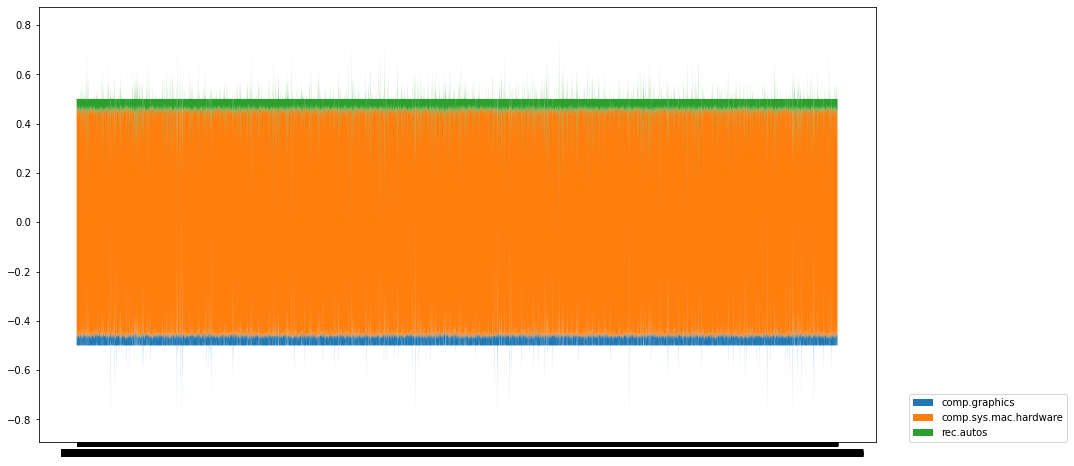

In [26]:
x_axis = ['DOC' + str(i) for i in range(len(norm_corpus))]
y_axis = doc_topic_df[['comp.graphics', 'comp.sys.mac.hardware', 'rec.autos']]

fig, ax = plt.subplots(figsize=(15, 8))

# Plot a stackplot - https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/stackplot_demo.html
ax.stackplot(x_axis, y_axis.T, baseline='wiggle', labels=y_axis.columns)

# Move the legend off of the chart
ax.legend(loc=(1.04, 0))

In [27]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_topic_matrix)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if ...",rec.autos,0
1,"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9...",comp.sys.mac.hardware,0
2,"From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus f...",comp.sys.mac.hardware,0
3,From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsread...,comp.graphics,0
4,"From: jcm@head-cfa.harvard.edu (Jonathan McDowell)\nSubject: Re: Shuttle Launch Question\nOrganization: Smithsonian Astrophysical Observatory, Cambridge, MA, USA\nDistribution: sci\nLines: 23\n\n...",sci.space,0
...,...,...,...
11309,"From: jim.zisfein@factory.com (Jim Zisfein) \nSubject: Re: Migraines and scans\nDistribution: world\nOrganization: Invention Factory's BBS - New York City, NY - 212-274-8298v.32bis\nReply-To: jim....",sci.med,0
11310,"From: ebodin@pearl.tufts.edu\nSubject: Screen Death: Mac Plus/512\nLines: 22\nOrganization: Tufts University - Medford, MA\n\nI have a (very old) Mac 512k and a Mac Plus, both of which \nhave the ...",comp.sys.mac.hardware,0
11311,From: westes@netcom.com (Will Estes)\nSubject: Mounting CPU Cooler in vertical case\nOrganization: Mail Group\nX-Newsreader: TIN [version 1.1 PL8]\nLines: 13\n\nI just installed a DX2-66 CPU in a ...,comp.sys.ibm.pc.hardware,0
11312,"From: steve@hcrlgw (Steven Collins)\nSubject: Re: Sphere from 4 points?\nOrganization: Central Research Lab. Hitachi, Ltd.\nLines: 27\nNntp-Posting-Host: hcrlgw\n\nIn article <1qkgbuINNs9n@shelley...",comp.graphics,0


In [28]:
import pyLDAvis
import pyLDAvis.sklearn
import dill
import warnings
warnings.filterwarnings('ignore')

pyLDAvis.enable_notebook()

In [30]:
tfidf_matrix = tfidf.fit_transform(norm_corpus)
pyLDAvis.sklearn.prepare(lda, tfidf_matrix, tfidf, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.075212  0.074846       1        1  90.846389
2      0.039495 -0.037605       2        1   4.778768
0      0.035717 -0.037241       3        1   4.374844, topic_info=             Term       Freq      Total Category  logprob  loglift
65167      israel  10.000000  10.000000  Default  30.0000  30.0000
65170     israeli   4.000000   4.000000  Default  29.0000  29.0000
20693    armenian   4.000000   4.000000  Default  28.0000  28.0000
20699   armenians   4.000000   4.000000  Default  27.0000  27.0000
121991    turkish   2.000000   2.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
8169           55   0.151162   1.455415   Topic3 -10.1569   0.8646
5647          333   0.086323   0.500528   Topic3 -10.7171   1.3717
37618          cx   0.099578   1.149448   Topic3 -10.5743   0.6832
84293          mv   0.087891   0.953203   Topic3 -10.6991   0.7456
84650   mydisplay   0.081387   1.614669   Topic3 -10.7760   0.1416

[147 rows x 6 columns], token_table=        Topic      Freq      Term
term                             
8169        1  0.687089        55
17947       1  0.995433      also
19268       1  0.998317    anyone
20346       1  0.673503      arab
20346       2  0.336752      arab
...       ...       ...       ...
124852      1  0.997992       use
126989      2  1.014553  villages
129419      1  0.990916      well
131100      1  1.001613     would
131283      1  0.998467    writes

[80 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [31]:
%%time
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# Options to try with our LDA
# Beware it will try *all* of the combinations, so it'll take ages
search_params = {'n_components': range(3,8), 'learning_decay': [.5, .7]}

# Set up LDA with the options we'll keep static
model = LatentDirichletAllocation(learning_method='online', ## `online` for large datasets
                                  max_iter=10,
                                  random_state=0)

# Try all of the options
gridsearch = GridSearchCV(model,
                          param_grid=search_params,
                          n_jobs=-1,
                          verbose=1)
gridsearch.fit(tfidf_matrix)

## Save the best model
best_lda = gridsearch.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.5min finished


Wall time: 6min 8s


# Hybrid Model  Performance

In [33]:
# What did we find?
print("Best Model's Params: ", gridsearch.best_params_)
print("Best Log Likelihood Score: ", gridsearch.best_score_)
print('Best Model Perplexity: ', best_lda.perplexity(tfidf_matrix))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -356842.55998251593
Best Model Perplexity:  64191.856657053344


In [34]:
cv_results_df = pd.DataFrame(gridsearch.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,52.694377,1.548196,2.052187,0.149837,0.5,3,"{'learning_decay': 0.5, 'n_components': 3}",-358145.784322,-357803.461255,-357237.468446,-357728.941521,374.551185,2,-669469.781512,-669819.941822,-670379.310615,-669889.677983,374.573665
1,64.943943,1.908143,1.889990,0.359981,0.5,4,"{'learning_decay': 0.5, 'n_components': 4}",-364569.968535,-364224.731560,-363608.586295,-364134.467292,397.646475,4,-675602.408314,-675946.088865,-676549.882675,-676032.793285,391.633467
2,74.560541,5.308921,1.966658,0.377944,0.5,5,"{'learning_decay': 0.5, 'n_components': 5}",-370854.122972,-370502.799728,-369839.813783,-370398.952395,420.558576,6,-681441.541474,-681780.091761,-682422.342927,-681881.325387,406.758780
3,92.732801,2.731989,2.693217,0.169681,0.5,6,"{'learning_decay': 0.5, 'n_components': 6}",-377003.530787,-376649.658844,-375949.382190,-376534.232090,438.034066,8,-686998.342345,-687330.183410,-688050.657088,-687459.727615,439.262909
4,100.696082,3.258859,2.360157,0.326883,0.5,7,"{'learning_decay': 0.5, 'n_components': 7}",-383066.959537,-382670.431772,-381966.035716,-382567.853126,455.274597,10,-692340.667789,-692621.997545,-693500.674616,-692821.113317,494.057539
5,66.558517,1.813828,1.953985,0.252984,0.7,3,"{'learning_decay': 0.7, 'n_components': 3}",-357253.320725,-356917.432745,-356356.817551,-356842.559983,369.812792,1,-667704.181750,-668053.750070,-668621.353664,-668126.428495,377.944172
6,71.604269,3.795108,1.700353,0.176080,0.7,4,"{'learning_decay': 0.7, 'n_components': 4}",-363568.877938,-363230.419940,-362619.936619,-363139.782762,392.677016,3,-673364.560470,-673698.210845,-674310.168691,-673790.980002,391.576569
7,78.418411,0.472747,1.763473,0.107810,0.7,5,"{'learning_decay': 0.7, 'n_components': 5}",-369779.712130,-369437.913639,-368779.558215,-369332.434198,415.075366,5,-678762.780137,-679090.568135,-679757.903790,-679203.750687,414.065606
8,80.014288,2.254508,1.418450,0.252236,0.7,6,"{'learning_decay': 0.7, 'n_components': 6}",-375879.674637,-375563.530695,-374868.899150,-375437.407254,422.182279,7,-683911.935783,-684281.571108,-685011.397611,-684401.634834,456.811815
9,75.792710,5.836971,0.717209,0.213462,0.7,7,"{'learning_decay': 0.7, 'n_components': 7}",-381889.212934,-381636.885094,-380835.901162,-381454.038197,449.036073,9,-688844.008527,-689310.516546,-690063.116942,-689405.880672,502.246333


In [36]:
import tmtoolkit
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
def topic_model_coherence_generator(topic_num_start=1,
                                    topic_num_end=5,
                                    norm_corpus='',
                                    cv_matrix='',
                                    cv=''):
    norm_corpus_tokens = [doc.split() for doc in norm_corpus]
    models = []
    coherence_scores = []

    for i in range(topic_num_start, topic_num_end):
        print(i)
        cur_lda = LatentDirichletAllocation(n_components=i,
                                            max_iter=10,
                                            random_state=0)
        cur_lda.fit_transform(tfidf_matrix)
        cur_coherence_score = metric_coherence_gensim(
            measure='c_v',
            top_n=5,
            topic_word_distrib=cur_lda.components_,
            dtm=cv.fit_transform(norm_corpus),
            vocab=np.array(cv.get_feature_names()),
            texts=norm_corpus_tokens)
        models.append(cur_lda)
        coherence_scores.append(np.mean(cur_coherence_score))
    return models, coherence_scores

<AxesSubplot:xlabel='param_n_components', ylabel='mean_test_score'>

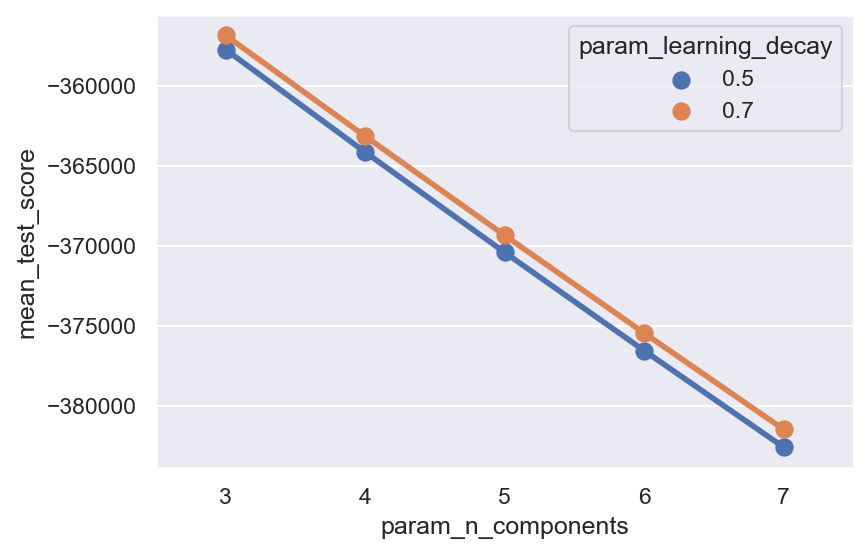

In [37]:
import seaborn as sns
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.pointplot(x="param_n_components",
              y="mean_test_score",
              hue="param_learning_decay",
              data=cv_results_df)

In [38]:
get_topics_meanings(best_lda.components_,
                    vocab,
                    display_weights=True,
                    weight_cutoff=2)

Topic #0 :
[]
Topic #1 :
[('would', 184.6), ('subject', 182.66), ('lines', 181.11), ('organization', 178.81), ('writes', 172.42), ('one', 167.78), ('article', 157.94), ('university', 157.65), ('nntppostinghost', 139.61), ('like', 137.03), ('dont', 130.83), ('people', 129.9), ('know', 129.04), ('get', 122.84), ('think', 112.42), ('im', 108.74), ('new', 105.46), ('good', 103.03), ('use', 99.04), ('distribution', 98.37), ('also', 97.03), ('time', 95.27), ('could', 95.24), ('anyone', 93.49), ('thanks', 88.67), ('god', 85.82), ('us', 84.27), ('well', 84.15), ('please', 83.62), ('system', 81.68), ('even', 81.07), ('computer', 80.98), ('need', 79.93), ('way', 79.63), ('much', 78.7), ('world', 77.84), ('may', 77.51), ('make', 76.81), ('usa', 76.72), ('see', 76.36), ('windows', 76.11), ('email', 75.81), ('want', 75.52), ('right', 75.37), ('go', 75.11), ('two', 74.13), ('first', 73.85), ('many', 73.79), ('say', 72.82), ('problem', 71.34), ('help', 70.61), ('work', 70.48), ('replyto', 69.88), ('r

Topic #2 :
[('ax', 9.56)]


In [40]:
new_texts = ['The sky is so blue', 'Love burger with ham']

new_texts_norm = normalize_corpus(new_texts)
new_texts_cv = tfidf.transform(new_texts_norm)
new_texts_cv.shape

(2, 136501)

In [41]:
new_texts_doc_topic_matrix = best_lda.transform(new_texts_cv)
topics = ['comp.graphics', 'comp.sys.mac.hardware', 'rec.autos']
new_texts_doc_topic_df = pd.DataFrame(new_texts_doc_topic_matrix,
                                      columns=topics)
new_texts_doc_topic_df['predicted_topic'] = [
    topics[i] for i in np.argmax(new_texts_doc_topic_df.values, axis=1)
]

new_texts_doc_topic_df['corpus'] = new_texts_norm
new_texts_doc_topic_df

,comp.graphics,comp.sys.mac.hardware,rec.autos,predicted_topic,corpus
0,0.138574,0.722851,0.138575,comp.sys.mac.hardware,sky blue
1,0.125555,0.748877,0.125568,comp.sys.mac.hardware,love burger ham


# Hybrid Model cv Coherence Score

In [43]:
import tmtoolkit
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
def topic_model_coherence_generator(topic_num_start=2,
                                    topic_num_end=6,
                                    norm_corpus='',
                                    cv_matrix='',
                                    cv=''):
    norm_corpus_tokens = [doc.split() for doc in norm_corpus]
    models = []
    coherence_scores = []

    for i in range(topic_num_start, topic_num_end):
        print(i)
        cur_lda = LatentDirichletAllocation(n_components=i,
                                            max_iter=10,
                                            random_state=0)
        cur_lda.fit_transform(tfidf_matrix)
        cur_coherence_score = metric_coherence_gensim(
            measure='c_v',
            top_n=5,
            topic_word_distrib=cur_lda.components_,
            dtm=cv.fit_transform(norm_corpus),
            vocab=np.array(cv.get_feature_names()),
            texts=norm_corpus_tokens)
        models.append(cur_lda)
        coherence_scores.append(np.mean(cur_coherence_score))
    return models, coherence_scores

In [46]:
%%time
ts = 2
te = 14
models, coherence_scores = topic_model_coherence_generator(
    ts, te, norm_corpus=norm_corpus, cv=tfidf, cv_matrix=tfidf_matrix)

2
3
4
5
6
7
8
9
10
11
12
13
Wall time: 17min 25s


In [47]:
coherence_scores

[0.7521630524212832,
 0.7397422943391275,
 0.5968501750719519,
 0.5042511833904781,
 0.5591528559332866,
 0.463527253367344,
 0.4516598997732755,
 0.37919303680009386,
 0.5743455075734022,
 0.3788439254272719,
 0.41228355114517257,
 0.3839412685519693]

In [48]:
coherence_df = pd.DataFrame({
    'TOPIC_NUMBER': [str(i) for i in range(ts, te)],
    'COHERENCE_SCORE': np.round(coherence_scores, 4)
})

coherence_df.sort_values(by=["COHERENCE_SCORE"], ascending=False)

,TOPIC_NUMBER,COHERENCE_SCORE
0,2,0.7522
1,3,0.7397
2,4,0.5969
8,10,0.5743
4,6,0.5592
3,5,0.5043
5,7,0.4635
6,8,0.4517
10,12,0.4123
11,13,0.3839


# Hybrid Model Umass Coherence Score 

In [49]:
import tmtoolkit
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
def topic_model_coherence_generator(topic_num_start=2,
                                    topic_num_end=6,
                                    norm_corpus='',
                                    cv_matrix='',
                                    cv=''):
    norm_corpus_tokens = [doc.split() for doc in norm_corpus]
    models = []
    coherence_scores = []

    for i in range(topic_num_start, topic_num_end):
        print(i)
        cur_lda = LatentDirichletAllocation(n_components=i,
                                            max_iter=10,
                                            random_state=0)
        cur_lda.fit_transform(tfidf_matrix)
        cur_coherence_score = metric_coherence_gensim(
            measure='u_mass',
            top_n=5,
            topic_word_distrib=cur_lda.components_,
            dtm=cv.fit_transform(norm_corpus),
            vocab=np.array(cv.get_feature_names()),
            texts=norm_corpus_tokens)
        models.append(cur_lda)
        coherence_scores.append(np.mean(cur_coherence_score))
    return models, coherence_scores

In [ ]:
%%time
ts = 2
te = 14
models, coherence_scores = topic_model_coherence_generator(
    ts, te, norm_corpus=norm_corpus, cv=tfidf, cv_matrix=tfidf_matrix)

2
3
4
5
6
7
8
9
10
11
12
13


In [ ]:
coherence_scores

In [ ]:
coherence_df = pd.DataFrame({
    'TOPIC_NUMBER': [str(i) for i in range(ts, te)],
    'COHERENCE_SCORE': np.round(coherence_scores, 4)
})

coherence_df.sort_values(by=["COHERENCE_SCORE"], ascending=False)